<a href="https://colab.research.google.com/github/kenanEkici/COVID19-fake-tweet-detection/blob/main/Masterproef_HCI_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Kenan Ekici

# Introduction

<img src="https://www.memesmonkey.com/images/memesmonkey/d0/d017cba8767eba32edc7e43e6132d4a7.jpeg" />

# Imports

In [ ]:
#lime
!pip install lime -q
import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular

# for hydrating tweet ids
!pip install twarc -q

#utils
import os
import re
import json
import random
from datetime import datetime
from shutil import copyfile
import string
from string import ascii_letters
from collections import Counter

#math, data
import numpy as np
from numpy import inf
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import math
from textblob import TextBlob

#plots, image
import cv2
from skimage import io
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ml, nlp
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import make_pipeline

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

     |████████████████████████████████| 276kB 13.1MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Collecting raw data

A dataset of Tweets and their corresponding label (fake news or not) is required in order to build a supervised machine learning classifier to detect Tweets that contain misinformation. As a result, the following sources have been collected which consist of Tweet ID's (a reference to the Tweet on Twitter). The second and third source contain news article contents and website claims with their corresponding label. These will be an additional source to mine language features that are deemed important to classify fake news, beyond the features learned from Tweets. The Tweets can contain any kind of information. However, we are mostly interested into claims and news articles regardless how it is presented, that is, objectively or subjectively. Recall that due to privacy reasons, the Tweets below have been compressed to the ID of the Tweet and the ID of the users. This ultimately means that we will need a third party library in order to collect the actual information that the ID's point to. In the context of Twitter, this is also referred to as, "rehydrating" the Tweets. In the next section, we will present a library for that purpose. Finally, we will also train a supervised classifier for detecting social bots as these were discussed to be an important source of fake news. The last proposed source contains ID's of users that were labeled as either social bot or real accounts. These must also be rehydrated using the third party library.   

Source #1: https://github.com/firojalam/COVID-19-tweets-for-check-worthiness (Downloaded 06-10-2020)

Source #2: https://github.com/cuilimeng/CoAID (Downloaded 06-10-2020)

Source #3: https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv (Downloaded 06-10-2020)

Source #4: http://mib.projects.iit.cnr.it/dataset.html

In [ ]:
# for convenience, we will download a bundle of all the sources from a Google drive endpoint
# if this endpoint does not work, please contact the author

# we dump all the raw files to the folder RawData
!rm -rf RawData
!rm -rf Junk
!rm -rf Classified
!gdown https://drive.google.com/uc?id=122tFro5g5u08M_DwLwYn5wDfHOR8BT48
!unzip RawData.zip
!rm RawData.zip

Downloading...
From: https://drive.google.com/uc?id=122tFro5g5u08M_DwLwYn5wDfHOR8BT48
To: /content/RawData.zip
8.51MB [00:00, 74.3MB/s]
Archive:  RawData.zip
   creating: RawData/
  inflating: RawData/covid19_infodemic_english_data.tsv  
  inflating: RawData/corona_fake.csv  
  inflating: RawData/cresci_fake_users.txt  
   creating: RawData/07-01-2020/
  inflating: RawData/07-01-2020/ClaimFakeCOVID-19.csv  
  inflating: RawData/07-01-2020/NewsFakeCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimFakeCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19_tweets_replies.csv  
  inflating: RawData/07-01-2020/ClaimRealCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/NewsFakeCOVID-19_tweets.csv  
  inflating: RawData/07-01-2020/NewsRealCOVID-19.csv  
  inflati

## Source 1

The first source contains COVID-19 related Tweets that have been extensively labeled by a community. The Tweets are categorized based on the answers they provide to the following questions:

- Q1: "Does the tweet contain a verifiable factual claim?"
- Q2: "To what extent does the tweet appear to contain false information?"
- Q3: "Will the tweet’s claim have an effect on or be of interest to the general public?"
- Q4: "To what extent does the tweet appear to be harmful to society, person(s), company(s) or product(s)?"
- Q5: "Do you think that a professional fact-checker should verify the claim in the tweet?"
- Q6: "Is the tweet harmful for society and why?"
- Q7: "Do you think that this tweet should get the attention of a government entity?"

The provided TSV file is loaded as a dataframe. The dataframe contains the ID and textual content of the Tweet as well as columnn that each represent one of the questions above. The columns (questions) have a variety of possible answers (refer to Github source 1). Thus, it is possible to filter out some of the Tweets from the dataframe that are not relevant. For the final misclassification Tweet dataset, we add every Tweet which contains the following answers: "yes" to question 1, "yes, probably or definitely contains false info" to question 2, and "yes, either urgent or not urgent" to question 5. 

In [ ]:
df = pd.read_csv('RawData/covid19_infodemic_english_data.tsv', sep='\t')

In [ ]:
df_1 = df.loc[df['q1_label'] == 'yes']
df_1 = df.loc[(df['q2_label'] == '4_yes_probably_contains_false_info') | (df['q2_label'] == '5_yes_definitely_contains_false_info')]
df_1 = df.loc[(df['q5_label'] == 'yes_not_urgent') | (df['q5_label'] == 'yes_very_urgent')]
df_1.head()

tweet_id  ...                    q7_label
4   1241447017945223169  ...          no_not_interesting
11  1240676575168921600  ...       yes_blame_authorities
13  1240768501452697600  ...       yes_blame_authorities
15  1241337295606657033  ...  yes_discusses_action_taken
19  1241057919128526856  ...  yes_discusses_action_taken

[5 rows x 9 columns]

In [ ]:
# We only need the Tweet ID's
tweets_fake_1 = df_1['tweet_id']

## Source 2

https://arxiv.org/pdf/2006.00885.pdf

The second source CoAID contains both factual and misleading COVID-19 claims from websites and news articles. It also contains Tweets that make COVID-19 related claims or share related news. The factual articles and claims have collected from reliable media outlets and websites such as WHO's official website.The fake news articles have been collected from fact-checking websites such as PolitiFact. The Tweets were queried based whether they contained news titles of misleading or factual news and thus labeled accordingly. The paper also presents important insights on the CoAID dataset such as the frequency of the hashtags used in both fake and real news and a list common claims. For our dataset, we collect only the labeled claims, news articles, and Tweets (both news and claims) but not the user replies. 

In [ ]:
def read_content_from_folder(dir_name): 
  fake_claims = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19.csv'))['title']
  fake_claims = pd.DataFrame({'content':fake_claims})
  fake_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimFakeCOVID-19_tweets.csv'))['tweet_id']
  fake_news =  pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19.csv'))[['title', 'content']]
  fake_news['content'] = fake_news['title'].replace(np.nan, '', regex=True) + ' ' + fake_news['content'].replace(np.nan, '', regex=True)
  fake_news = pd.DataFrame({'content':fake_news['content']})
  fake_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsFakeCOVID-19_tweets.csv'))['tweet_id']

  real_claims = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19.csv'))['title']
  real_claims = pd.DataFrame({'content':real_claims})
  real_claims_tweets = pd.read_csv(os.path.join(dir_name, 'ClaimRealCOVID-19_tweets.csv'))['tweet_id']
  real_news =  pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19.csv'))[['title', 'content']]
  real_news['content'] = real_news['title'].replace(np.nan, '', regex=True) + ' ' + real_news['content'].replace(np.nan, '', regex=True)
  real_news = pd.DataFrame({'content':real_news['content']})
  real_news_tweets = pd.read_csv(os.path.join(dir_name, 'NewsRealCOVID-19_tweets.csv'))['tweet_id']

  return [fake_claims, fake_claims_tweets, fake_news, fake_news_tweets, real_claims, real_claims_tweets, real_news, real_news_tweets]

l1 = read_content_from_folder('RawData/05-01-2020/')
l2 = read_content_from_folder('RawData/07-01-2020/')

all_dfs = []

# merging two lists, reset index
for i, dataframe in enumerate(l1):
  all_dfs.append(dataframe.append(l2[i], ignore_index=True))

fc, fct, fn, fnt, rc, rct, rn, rnt = all_dfs

In [ ]:
# join previous fake claims tweet id's with new collectd id's
fct = tweets_fake_1.append(fct, ignore_index=True)

## Source 3

The third source contains around 500 factual and 500 misleading news articles collected by the author of https://towardsdatascience.com/covid-fake-news-detection-with-a-very-simple-logistic-regression-34c63502e33b, senior data scientist Susan Li. We collect both the content and the title of the articles and combine them in one column. 

In [ ]:
# code from: https://github.com/susanli2016/NLP-with-Python/blob/master/Fake_News_LogReg.ipynb
df = pd.read_csv('RawData/corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

df = df.sample(frac=1).reset_index(drop=True)
df.title.fillna('missing', inplace=True)
df.source.fillna('missing', inplace=True)

df['title_text'] = df['title'] + ' ' + df['text']
def preprocessor(text):
    
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text
    
df['title_text'] = df['title_text'].apply(preprocessor)
df['label'].value_counts()

TRUE    586
FAKE    578
Name: label, dtype: int64

In [ ]:
df_t = pd.DataFrame({'content':df.loc[df['label']=='TRUE']['title_text']})
df_f = pd.DataFrame({'content':df.loc[df['label']=='FAKE']['title_text']})

In [ ]:
fn = fn.append(df_f, ignore_index=True)
rn = rn.append(df_t, ignore_index=True)

## Source 4

The last dataset contains a list of Twitter user ID's of both bots and real accounts which have been labeled through CrowdFlower, a crowdsourcing platform. This data will be necessary to train the social bot classifier in a later section. Due to privacy reasons, the dataset may not be distributed. You can request the dataset from the authors or use another source. For the latter case, please replace the file paths below with the path of a text file containing a list of Twitter user ID's. 

In [ ]:
bot_user_id = pd.read_csv("RawData/cresci_fake_users.txt", header=None)
real_user_id = pd.read_csv("RawData/cresci_real_users.txt", header=None)

## Raw dataframes

We now have collected all of the necessary data. Although the claims and articles are raw strings, the Tweets are ID's (due to privacy reasons) and thus must be fetched explictely from the Twitter API. In the next section, we will use Twarc to fetch the Twitter level data.   

In [ ]:
dataframes = [("fake_claims", fc), ("fake_claims_tweets", fct), ("fake_news", fn), ("fake_news_tweets", fnt), 
              ("real_claims", rc), ("real_claims_tweets", rct), ("real_news", rn), ("real_news_tweets", rnt),
              ("bot_users", bot_user_id), ("real_users", real_user_id)]

[print(i[0], len(i[1])) for i in dataframes]
print()

fake_claims 28
fake_claims_tweets 644
fake_news 1416
fake_news_tweets 10416
real_claims 338
real_claims_tweets 7795
real_news 3303
real_news_tweets 141548
bot_users 3455
real_users 3474



# Rehydrating tweet IDS

We will use Twarc to rehydrate the Twitter ID's that we collected in the previous section. Twarc will rehydrate the ID's and collect the Twitter level data. This includes the Tweet and the data of the user that posted the Tweet. We will rehydrate both the Tweet ID's and the user ID's that we have collected in the previous section. In order to use Twarc, you will need a Twitter developer key and access token which you can request from the Twitter developer API.  


In [ ]:
# you can ignore this variable
# this will always be False if you are not the author of this notebook
author = True

# for temps files
!mkdir Junk

if not author:
  tweets_fake = fnt.append(fct, ignore_index=True)
  tweets_true = rnt.append(rct, ignore_index=True)

  # we combine all found tweet IDS
  print(len(tweets_fake), len(tweets_true))

  with open("Junk/tweets_fake.txt", "w") as f:
      for line in tweets_fake:
          f.write(str(line)+"\n") 

  with open("Junk/tweets_real.txt", "w") as f:
      for line in tweets_true:
          f.write(str(line)+"\n") 

  copyfile("RawData/cresci_fake_users.txt", "Junk/cresci_fake_users.txt")
  copyfile("RawData/cresci_real_users.txt", "Junk/cresci_real_users.txt")

  # Need a Twitter dev account and keys
  !twarc configure

  !mkdir Classified

  !twarc hydrate Junk/tweets_fake.txt > Classified/tweets_fake.jsonl
  !twarc hydrate Junk/tweets_real.txt > Classified/tweets_real.jsonl
  !twarc users Junk/cresci_real_users.txt > Classified/real_users.jsonl
  !twarc users Junk/cresci_fake_users.txt > Classified/fake_users.jsonl
else:
  # only the author can retrieve the prepopulated data from a personal Google drive folder
  !gdown https://drive.google.com/uc?id=1eSc4OM4-AOh0E829ShObkHk_NpiGGlL-
  !unzip Classified.zip
  !rm Classified.zip

def read_json(filename):
  tweets = []
  with open(filename) as f:
    for line in f:
      tweets.append(json.loads(line))
  return tweets  

mkdir: cannot create directory ‘Junk’: File exists
Downloading...
From: https://drive.google.com/uc?id=1eSc4OM4-AOh0E829ShObkHk_NpiGGlL-
To: /content/Classified.zip
68.1MB [00:00, 146MB/s] 
Archive:  Classified.zip
replace Classified/tweets_real.jsonl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Classified/tweets_real.jsonl  
  inflating: Classified/fake_users.jsonl  
  inflating: Classified/real_users.jsonl  
  inflating: Classified/tweets_fake.jsonl  


As you can verify below, after collecting the Tweets from the API, the amount of entries are a lot less than the actual raw data. This is because some of the Tweets (and users) may have been deleted and thus resulted into empty entries.

In [ ]:
# these contain both Tweet data and user data
tweets_fake = read_json('Classified/tweets_fake.jsonl')
tweets_real = read_json('Classified/tweets_real.jsonl')

# these only contain user data
users_fake = read_json('Classified/fake_users.jsonl')
users_real = read_json('Classified/real_users.jsonl')

#sanity check
print(len(tweets_fake))
print(len(tweets_real))
print(len(users_fake))
print(len(users_real))

10165
142761
2804
2892


# Filtering and mining Tweet level features

Now that we have collected the Tweets and users in JSON format, we can determine which columns we want to keep for the final dataset. After all, the API returns a large set of columns and features. Some of these feature are not necessary for building the classifiers. We have defined two helper functions to convert the JSON files of both Tweets and users to a Pandas dataframe. This will be easier to work with when doing analysis. We will also simultaneously filter the columns that are redundant. 

In [ ]:
tweet_columns = ["id", "source", "full_text", "retweet_count", "favorite_count", "possibly_sensitive"]
user_columns = ["id", "name", "screen_name", "has_extended_profile", "location", "description", "url", "protected", "followers_count", "friends_count", "listed_count", "created_at", "favourites_count", "geo_enabled", "verified", "statuses_count", "contributors_enabled", "is_translator", "is_translation_enabled", "profile_image_url", "profile_use_background_image", "default_profile", "default_profile_image", ]

# this function will be used to convert the json files that contain
# both the tweet level and user level data to a Pandas dataframe
def json_to_dataframe(json, amount):
  tweets = []
  users = []
  for i, t in enumerate(json):
    tweet_row = []
    user_row = []
    for _, tc in enumerate(tweet_columns):
      if (tc == "possibly_sensitive"):
        if "possibly_sensitive" in t:
          tweet_row.append(t["possibly_sensitive"])
        else:
          tweet_row.append(False)
      else:
        tweet_row.append(t[tc])    
    for _, tu in enumerate(user_columns):
      user_row.append(t['user'][tu])
    tweets.append(tweet_row)
    users.append(user_row)
  df_t = pd.DataFrame(data= tweets, columns=tweet_columns)
  df_u = pd.DataFrame(data=users, columns=user_columns)

  return df_t[0:amount], df_u[0:amount]

# this function will be used to convert only the json files
# that contain user level data to a Pandas dataframe
def user_json_to_dataframe(json):
  users = []
  for i, u in enumerate(json):
    user_row = []
    for _, tu in enumerate(user_columns):
      user_row.append(u[tu])
    users.append(user_row)
  df_u = pd.DataFrame(data=users, columns=user_columns)
  return df_u

The literature and related work in [] proposes a variety of techniques meant to improve classification of anomalous behavior such as social bots or fake news. Data mining is such a technique in which new knowledge is inferred from existing data. We will use this technique to generate new columns from the existing ones that were retreived from the API. An example of these features are username length, likes and age ratio or the ratio of friends to followers. The following functions will be used to mine such features. 

In [ ]:
def calculate_ratio(mined_data):
  mined_data['ratio'] = (mined_data['followers_count'] / mined_data['friends_count'])
  return mined_data['ratio'].replace([np.inf, -np.inf], np.nan).fillna(1)

def preprocess(data, keep_all=False):

  if (keep_all):
    mined_data = data.copy()
  else:
    mined_data = data[['followers_count', 'friends_count', 'has_extended_profile', 'favourites_count', 'verified', 'statuses_count', 'default_profile_image', 'default_profile', 'protected']].copy()
  
  mined_data['bio_length'] = data['description'].apply(len)
  mined_data['username_length'] = data['screen_name'].apply(len)
  mined_data['name_length'] = data['name'].apply(len)
  date_format = "%a %b %d %H:%M:%S +%f %Y" 
  mined_data['age_account_days'] = 0
  for i, r in enumerate(data['created_at']):
    a = datetime.now()
    b = datetime.strptime(r, date_format)
    mined_data['age_account_days'].iloc[i] = (a - b).days
  
  mined_data['ratio'] = calculate_ratio(mined_data)
  mined_data['likes_age_ratio'] = (mined_data['favourites_count'] / mined_data['age_account_days']).fillna(0)
  mined_data['likes_age_ratio'] = mined_data['likes_age_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1)
  mined_data['verified'] = mined_data['verified'].astype(int)
  mined_data['has_location'] = data['location'] != ''
  mined_data['has_location'] = mined_data['has_location'].astype(int)
  mined_data['default_profile_image'] = mined_data['default_profile_image'].astype(int)
  mined_data['has_extended_profile'] = mined_data['has_extended_profile'].astype(int)
  mined_data['default_profile'] = mined_data['default_profile'].astype(int)
  mined_data['protected'] = mined_data['protected'].astype(int)
 
  return mined_data

During the retrieval of the raw data, it was rather evident that there was more data of normal behavior (factual news), then there is of anomalous behavior (fake news). This is a known problem in supervised classification of anomalous behavior which is due the fact that anomalies occur less often. Below, we make sure that we maintain a balanced dataset for training. 

In [ ]:
# these contain fake/real news and claims of Twitter users 
# as well as the users that posted them
amount = 10000
tweets_fake, tweets_fake_users = json_to_dataframe(tweets_fake, amount)
tweets_real, tweets_real_users = json_to_dataframe(tweets_real, amount)

# we preprocess the previous users and mine relevant features
tweets_fake_users = preprocess(tweets_fake_users)
tweets_real_users = preprocess(tweets_real_users)

# we also keep a copy of the user dataframes with all the attributes
# this will be for the presentation of tweets during the user study
tweets_fake_users_study = preprocess(tweets_fake_users, True)
tweets_real_users_study = preprocess(tweets_real_users, True)

# these will be used to train the social bot detector 
bots = preprocess(user_json_to_dataframe(users_fake))
non_bots = preprocess(user_json_to_dataframe(users_real))

# Finalized dataset

We have now collected all the required data and mined the features that are necessary for further analysis and the development of the supervised classifiers. However, before we develop the classifiers, we must do analyze the dataset in order to gain an insight on both the features and their correlation with the target labels that we aim to predict. This process will help to determine which features are useful and which are not.

**The final dataset that we will continue using consists of:**



In [ ]:
fake_news_articles = fn
real_news_articles = rn
print(len(fake_news_articles), "Fake and", len(real_news_articles), "real news articles (text)")

fake_claims = fc
real_claims = rc
print(len(fake_claims), "fake and", len(real_claims), "real website claims (text)")

print(len(tweets_fake), "fake and", len(tweets_real), "real news and claims (tweets)")

print("The corresponding", len(tweets_fake_users)+len(tweets_real_users) ,"users that posted these fake real claims and news (users) - version for analysis")

print("The corresponding", len(tweets_fake_users_study)+len(tweets_real_users_study) ,"users that posted these fake real claims and news (users) - version for user study")

 
print(len(bots), "bots and", len(non_bots), "real users (users)")

1416 Fake and 3303 real news articles (text)
28 fake and 338 real website claims (text)
10000 fake and 10000 real news and claims (tweets)
The corresponding 20000 users that posted these fake real claims and news (users) - version for analysis
The corresponding 20000 users that posted these fake real claims and news (users) - version for user study
2804 bots and 2892 real users (users)


# Data analysis

We must analyze the data to find features that are highly correlated with the target label (fake or not fake news). In this section, we will analyze the Twitter data which consists of both the Tweet level data and user level data. In order to do this, we explicitly label fake news (and claims) with the number one, and the factual news (and claims) with zero.  

In [ ]:
# 20K users 
tweets_users = (tweets_fake_users.append(tweets_real_users, ignore_index=True))
# 20K tweets
tweets = (tweets_fake.append(tweets_real, ignore_index= True))
# 20K corresponding labels
y = np.concatenate((np.ones(len(tweets_fake)), np.zeros(len(tweets_real))))
tweets['label'] = y
tweets_users['label'] = y 

## Social impact

The first analysis will be that of social impact as each Tweet contains both the amount of retweets and favorites. Below, we plot the social impact that each Tweet has on a scatterplot. Hereby, we can confirm that fake news is spread and favorited a lot more than real news! When we inspect the scatterplot more closely (second figure), we can see that the odds of a Tweet being fake increases when it has more than 100 favorites and 100 retweets.

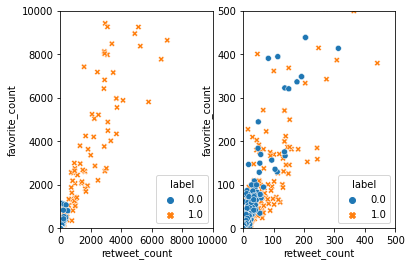

In [ ]:
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(data=tweets, x="retweet_count", y="favorite_count", style="label", hue="label", ax=axs[0])
axs[0].set_xlim(0,10000)
axs[0].set_ylim(0,10000)
ax = sns.scatterplot(data=tweets, x="retweet_count", y="favorite_count", style="label", hue="label", ax=axs[1])
axs[1].set_xlim(0,500)
axs[1].set_ylim(0,500)
print()

## Tweet text

We also consider linguistic features which might be strong indicators for fake news. These features are:
- length of the tweet
- number of question marks, exclamation marks, uppercased characters, number of hashtags
- whether the contains a URL
- whether the Tweet is subjective or objective
- marked by Twitter as sensitive

In [ ]:
# helper function to mine the linguistic features
def add_amount_features(col_name, char):
  tweets[col_name] = 0
  for i, s in enumerate(tweets['full_text']):
    n_q = 0
    for k in s:
      if (k == char):
        n_q +=1
    tweets[col_name].loc[i] = n_q

add_amount_features('n_question', '?')
add_amount_features('n_exclaim', '!')
add_amount_features('n_hash', '#')

tweets['n_uppercase'] = tweets['full_text'].str.findall(r'[A-Z]').str.len()
tweets['length'] = tweets['full_text'].str.len()

We can see that the plots below do not show notable differences between the linguistic features of fake and real news Tweets except for the last plot indicating that fake news might include more uppercases than baseline behavior.  

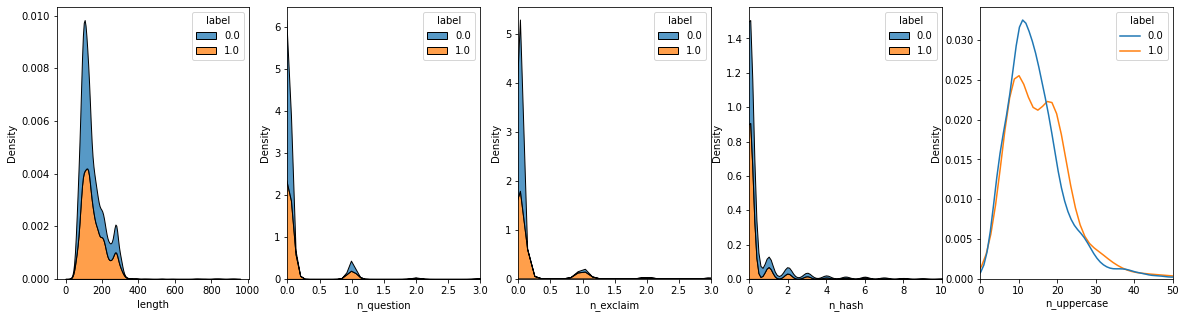

In [ ]:
fig, axs = plt.subplots(ncols=5, figsize=(20,5))
sns.kdeplot(data=tweets, x="length", hue="label", multiple="stack", ax=axs[0])
sns.kdeplot(data=tweets, x="n_question", hue="label",multiple="stack", ax=axs[1])
axs[1].set_xlim(0,3)
sns.kdeplot(data=tweets, x="n_exclaim", hue="label",multiple="stack", ax=axs[2])
axs[2].set_xlim(0,3)
sns.kdeplot(data=tweets, x="n_hash", hue="label", multiple="stack", ax=axs[3])
axs[3].set_xlim(0,10)
sns.kdeplot(data=tweets, x="n_uppercase", hue="label", ax=axs[4])
axs[4].set_xlim(0,50)
print()

In [ ]:
tweets['has_link'] = False
for i, s in enumerate(tweets['full_text']):
  tweets['has_link'].loc[i] = ('t.co' in s) or ('http' in s)

f1_score(tweets["has_link"], y)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0.634251530328325

In [ ]:
#https://medium.com/pew-research-center-decoded/detecting-subjectivity-and-tone-with-automated-text-analysis-tools-5f0e662224b8
def textblob_adj(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    adj_list = []
    adv_list = []
    adj_tag_list = ['JJ','JJR','JJS']
    adv_tag_list = ['RB','RBR','RBS']
    for (a, b) in blobed.tags:
        if b in adj_tag_list:
           adj_list.append(a)
        elif b in adv_tag_list:
           adv_list.append(a)
        else:
            pass
    return adj_list, adv_list, counts['JJ']+counts['JJR']+counts['JJS'], counts['RB']+counts['RBR']+counts['RBS']
    
#https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7
 
# TODO: clean the tweets
tweets['subjective'] = 0
tweets['adj_c'] = 0
tweets['adv_c'] = 0
for i, s in enumerate(tweets['full_text']):
  adj, adv, adj_c, adv_c = textblob_adj(s)
  tweets['adj_c'].loc[i] = adj_c
  tweets['adv_c'].loc[i] = adv_c
  if (adv_c >= 3):
    tweets['subjective'].loc[i] = 1
print(tweets['subjective'].value_counts())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0    18977
1     1023
Name: subjective, dtype: int64


In [ ]:
f1_score(tweets["subjective"], y)

0.10850040823732196

In [ ]:
f1_score(tweets["possibly_sensitive"],y)

0.06461974492205952

## User characteristics and fake news

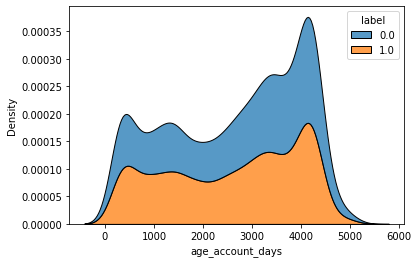

In [ ]:
sns.kdeplot(data=tweets_users, x="age_account_days", hue="label", multiple="stack")

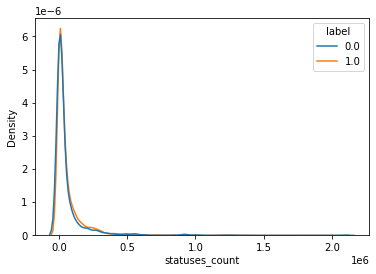

In [ ]:
sns.kdeplot(data=tweets_users, x="statuses_count", hue="label")

In [ ]:
tweets_users["ratio_2"] = (tweets_users["ratio"]*100).round(0)

for i,k in tweets_users.iterrows():
  if k["ratio_2"] > 1000: 
      tweets_users["ratio_2"].loc[i] = 0

tweets_users["ratio_2"].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0.0      1600
100.0     725
91.0      282
92.0      227
99.0      224
         ... 
404.0       1
671.0       1
834.0       1
685.0       1
482.0       1
Name: ratio_2, Length: 739, dtype: int64

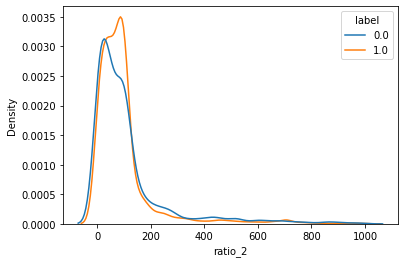

In [ ]:
sns.kdeplot(data=tweets_users, x="ratio_2", hue="label")

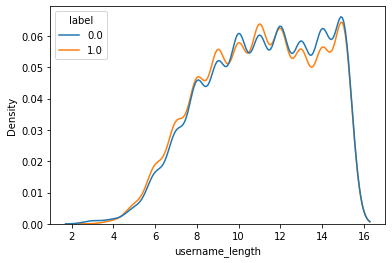

In [ ]:
sns.kdeplot(data=tweets_users, x="username_length", hue="label")

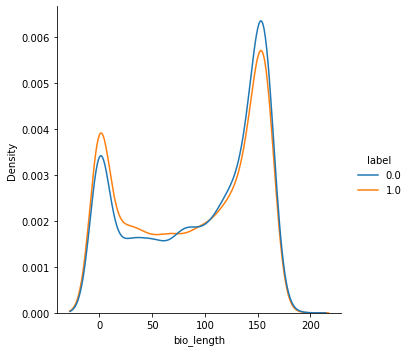

In [ ]:
sns.displot(tweets_users, x="bio_length", hue="label", kind="kde")

(-30.0, 100.0)

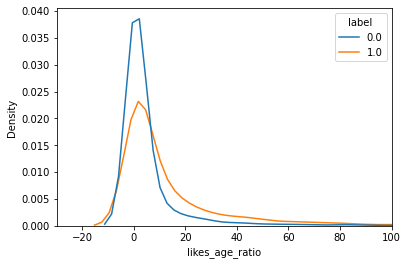

In [ ]:
ax = sns.kdeplot(data=tweets_users, x="likes_age_ratio", hue="label")
ax.set_xlim(-30,100)

In [ ]:
print(f1_score(y,tweets_users['default_profile_image'].astype(int)))
print(f1_score(y, tweets_users['protected'].astype(int)))
print(f1_score(y, tweets_users['verified'].astype(int)))
print(f1_score(y, tweets_users['has_location'].astype(int)))

0.09533431300514326
0.0
0.051016566265060244
0.5715919767964378


## Feature correlation and selection

In [ ]:
if False:
  sns.set_theme(style="white")

  # Generate a large random dataset

  d = X

  # Compute the correlation matrix
  corr = d.corr()

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Spam and duplication

Hashing does not work,

Duplicated tweets are almost never equal 
-> users copy pasta + tags or usernames or own personal comments

In [ ]:
#https://gist.github.com/ahmetalsan/06596e3f2ea3182e185a



def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)


def get_result(content_a, content_b):
    text1 = content_a
    text2 = content_b

    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    cosine_result = get_cosine(vector1, vector2)
    return cosine_result


In [ ]:
# tradeoff # clusters <-> # uniques found
# higher cosine similarity -> smaller and more clusters -> more uniques than ground truth
# lower cosing similarity -> larger and less clusters -> less uniques than ground truth
# what is the ground truth?????? We can only know if we inspect everything -> infeasible with 10K tweets
if False:

  cos_threshold = 0.9

  tweets_ = []


  for j,r in tweets_fake.iterrows():
    tweets_.append(r['full_text'])

  from collections import defaultdict

  book = defaultdict()
  for i, a in enumerate(tweets_):
    if (a != ""):
      print(i)
      to_join = []
      for j, b in enumerate(tweets_):
        if (i != j):
          if (b != ""):
            if (get_result(a,b) >= cos_threshold):
              to_join.append(j)
              tweets_[j] = ""
      if (len(to_join) > 0):
        book[i] = to_join
      else:
        book[i] = [i]
      tweets_[i] = ""

  c = 0
  for i, k in enumerate(book):
    if len(book[k]) > 0:
      c+=1

  print("# unique tweets before clusting: ", len(tweets_fake))
  print("# unique tweets after clusting: ", c)
  print("Reduction of: ", int(((len(tweets_fake)-c)/len(tweets_fake))*100), "%")
  print("Realistic? Use same cosine threshold for real tweets and compare reduction")
  print("Hypothesis = fake news spreads more than real news")
  print("Hypothesis is not true for this dataset. Both have similar reduction rates for a given cosine similarity.")
  print(book)

  for i in book[1643]:
    print(tweets_fake['full_text'].loc[i])
    print()


## Word cloud visualisation

### Generate hashtag word clouds

In [ ]:
# extract hashtags
tweets_fake["hashtag"] = tweets_fake["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))
tweets_real["hashtag"] = tweets_real["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))

In [ ]:
too_obv = ["corona", "covid", "virus", "http", '#corona', "#covid", "#virus"]
obv = [ "people", "health", "new", "disease", 
       "pandemic", "will", "may", "–"]


def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def clean(content):
  words = content.split()
  result  = [word.lower() for word in words if word.lower().strip() not in obv and not word.lower().strip().startswith(tuple(too_obv))]
  content = ' '.join(result)
  content = remove_punct(content)
  return content

# Hashtags Fake news

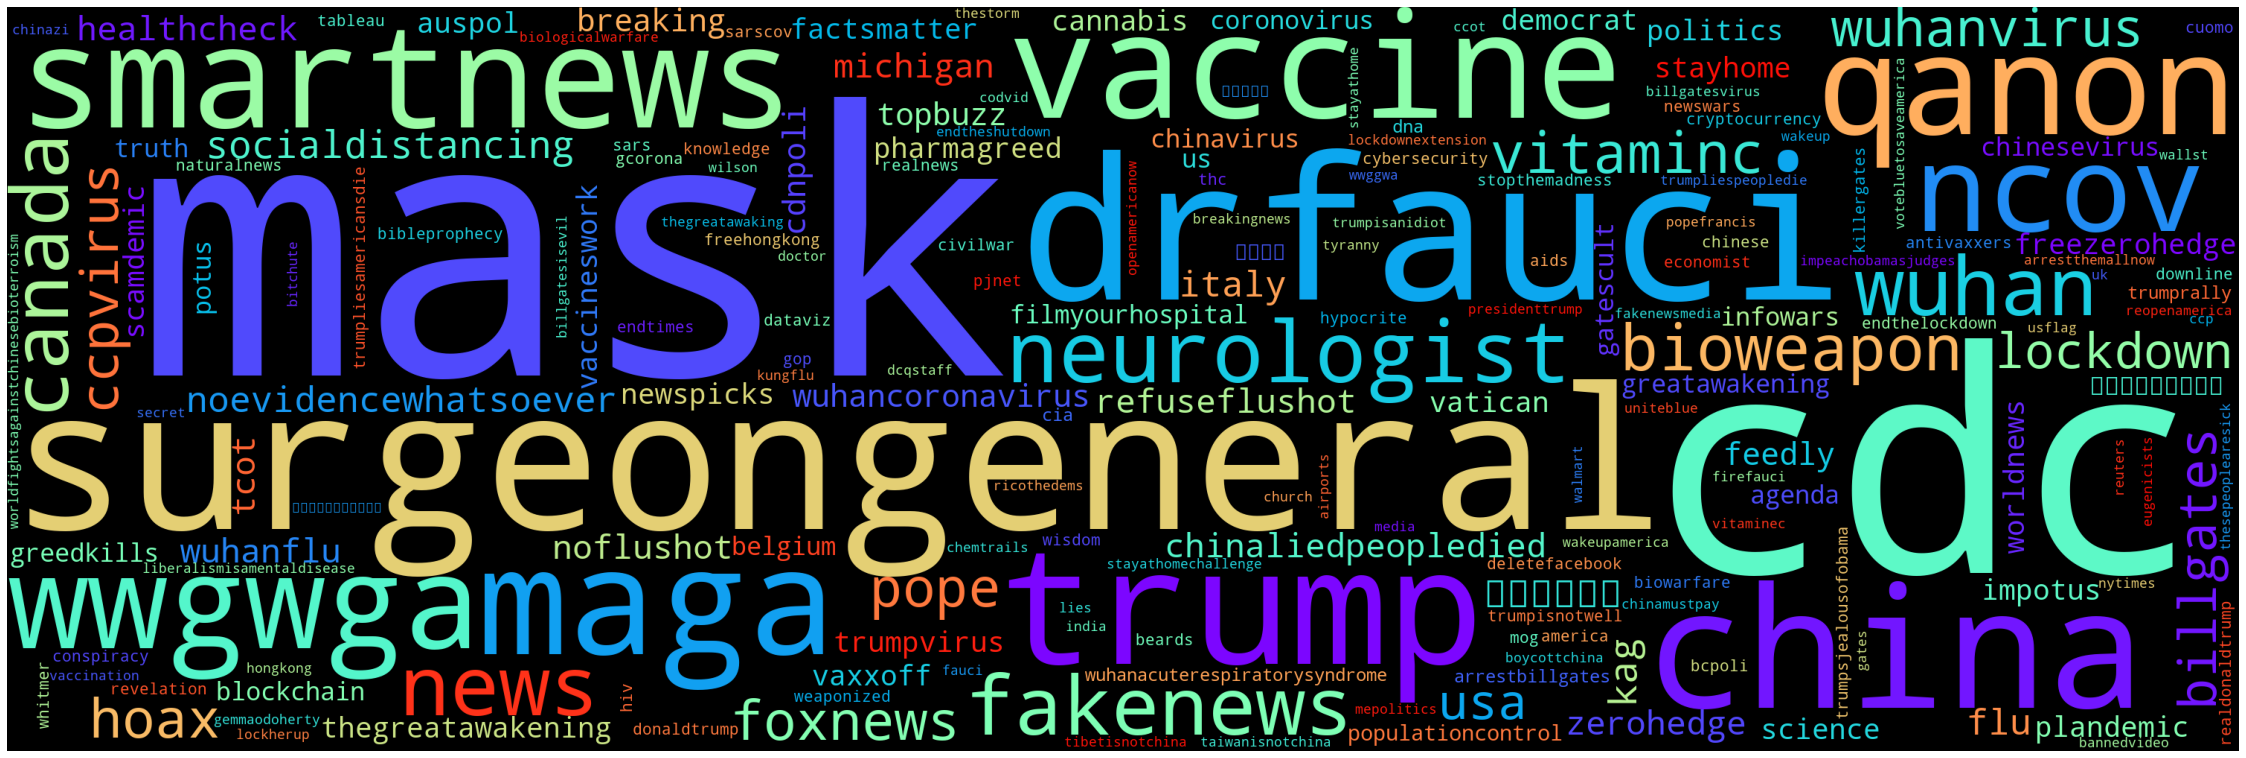

In [ ]:
fake_news_hashtags = []

# https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

def frame_to_words(df, fake):
  words = ""
  for i, k in df.iterrows():
    for hash in k["hashtag"]:
      if fake: fake_news_hashtags.append(hash)
      words += " " + hash + " "
  return clean(words)

words = frame_to_words(tweets_fake, True)
wordcloud = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)
# Plot
printmd("# Hashtags Fake news")
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off");

# Hashtags Real news

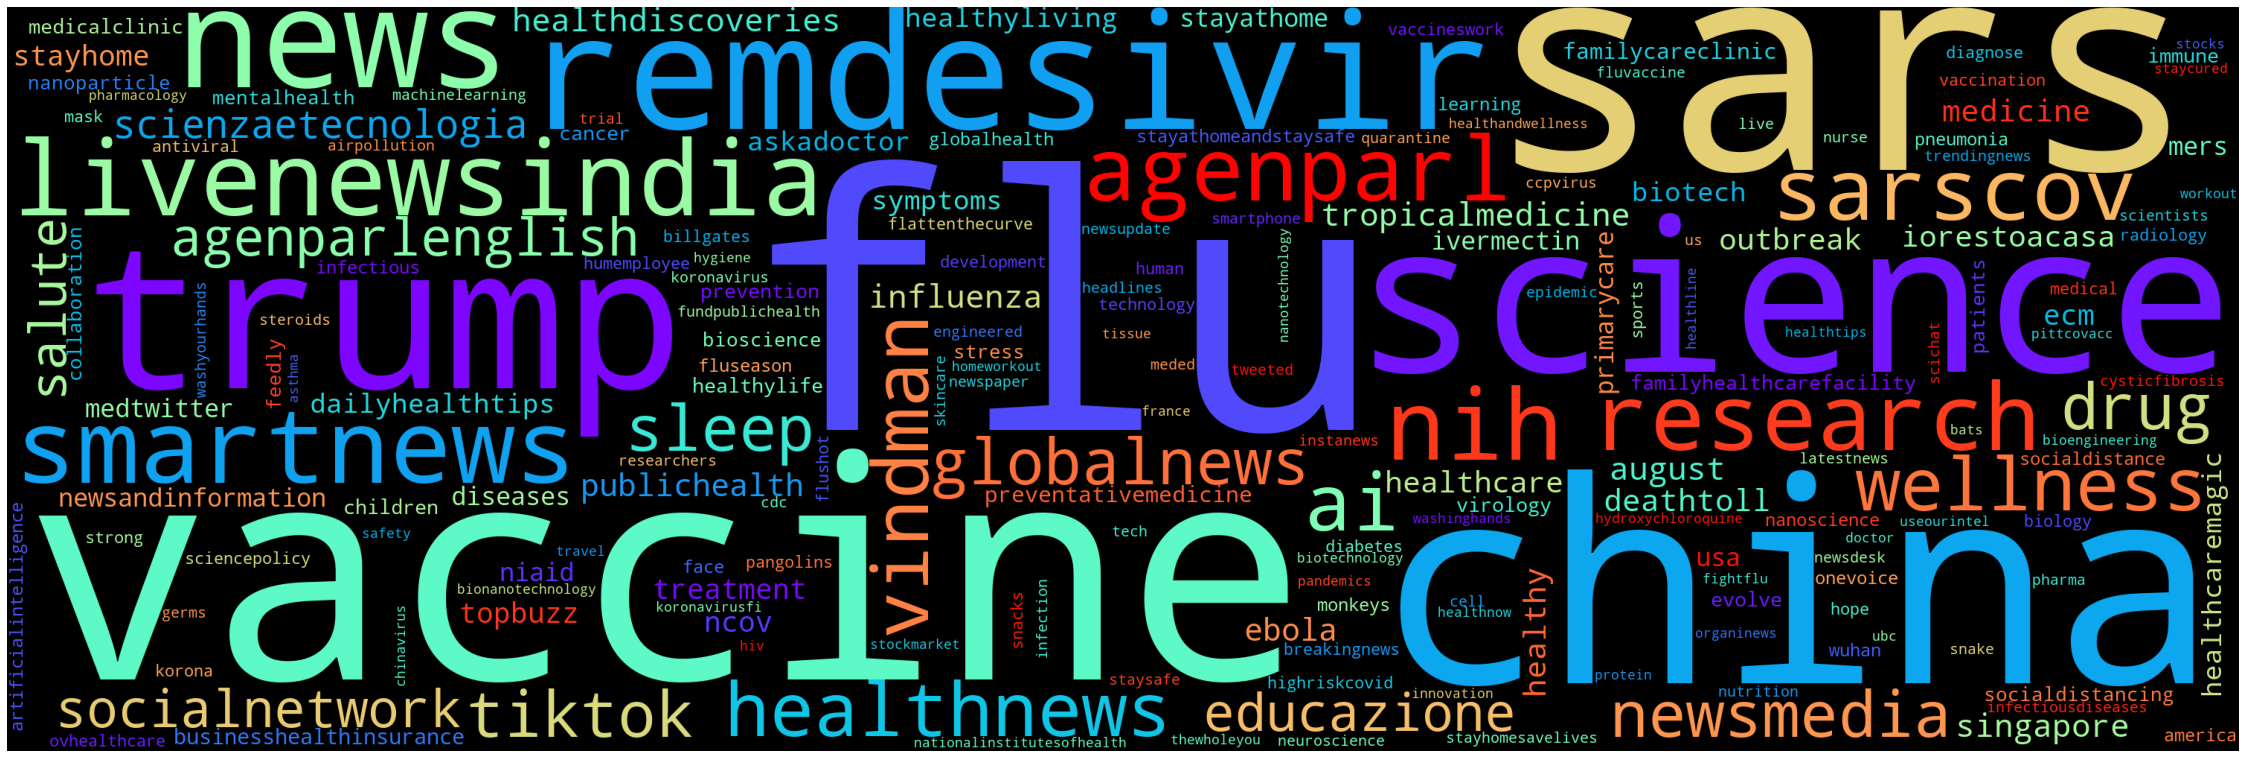

In [ ]:
words = frame_to_words(tweets_real, False)
wordcloud = WordCloud(width = 3000, height = 1000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS).generate(words)
# Plot
printmd("# Hashtags Real news")
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off");

# Building a TF IDF Fake news classifier with word heatmap

TODO: build TF only hashtag classifier?

## Data

In [ ]:
def collect_from_sources(news, claims, tweets):
  content = []

  for i, cont in news.iterrows():
    content.append(clean(cont['content']))

  for i, cont in claims.iterrows():
    content.append(clean(cont['content']))

  for i, cont in tweets.iterrows():
    content.append(clean(cont['full_text']))
  
  return content

fake = collect_from_sources(fake_news_articles, fake_claims, tweets_fake)
real = collect_from_sources(real_news_articles, real_claims, tweets_real)

y = np.concatenate((np.ones(len(fake), dtype=np.uint16), np.zeros(len(real), dtype=np.uint16)))

In [ ]:
data = []

for f in fake:
  data.append(f)

real_ = random.sample(real, len(fake))
for r in real_:
  data.append(r)

In [ ]:
y_ = y[0:len(data)]

# sanity check
print(len(data))
print(len(y))

22888
25085


## Stem + TFIDF

In [ ]:
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf = TfidfVectorizer(stop_words='english',
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        max_features=1000,
                        ngram_range=(1,2))
X = tfidf.fit_transform(data)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

In [ ]:
 features = tfidf.get_feature_names()
 len(features)

1000

## Word cloud features

In [ ]:
def plot_cloud(words, label):
  
  printmd("# "+ label+ "News")
  if (label == "Fake"):
    !wget -P Junk "https://techcentral.co.za/wp-content/uploads/2019/05/donald-trump-2156-1120.jpg" -q
    mask = np.array(Image.open('Junk/donald-trump-2156-1120.jpg'))
  else:
    !wget -P Junk "https://static01.nyt.com/images/2014/08/10/magazine/10wmt/10wmt-superJumbo-v4.jpg" -q
    mask = np.array(Image.open('Junk/10wmt-superJumbo-v4.jpg'))
  
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords = STOPWORDS, mask=mask).generate(words)

  # Set figure size
  plt.figure(figsize=(40, 30))
  # Display image
  plt.imshow(wordcloud) 
  # No axis details
  plt.axis("off");


def plot_important_tfidf_features(matrix, label, feature_tfidf_threshold):

  f = np.zeros(len(features))

  for feature_vector in enumerate(matrix.todense()): 
    vector = np.array(feature_vector[1]).flatten()
    result = np.where(vector>=feature_tfidf_threshold)
    for i in result[0]:
      f[i] += 1

  words = ""
  for i, k in enumerate(f):
    if (k != 0):
      for _ in range(0,int(k)):
        words += " " + features[i]
  # Plot
  plot_cloud(words, label)


# FakeNews

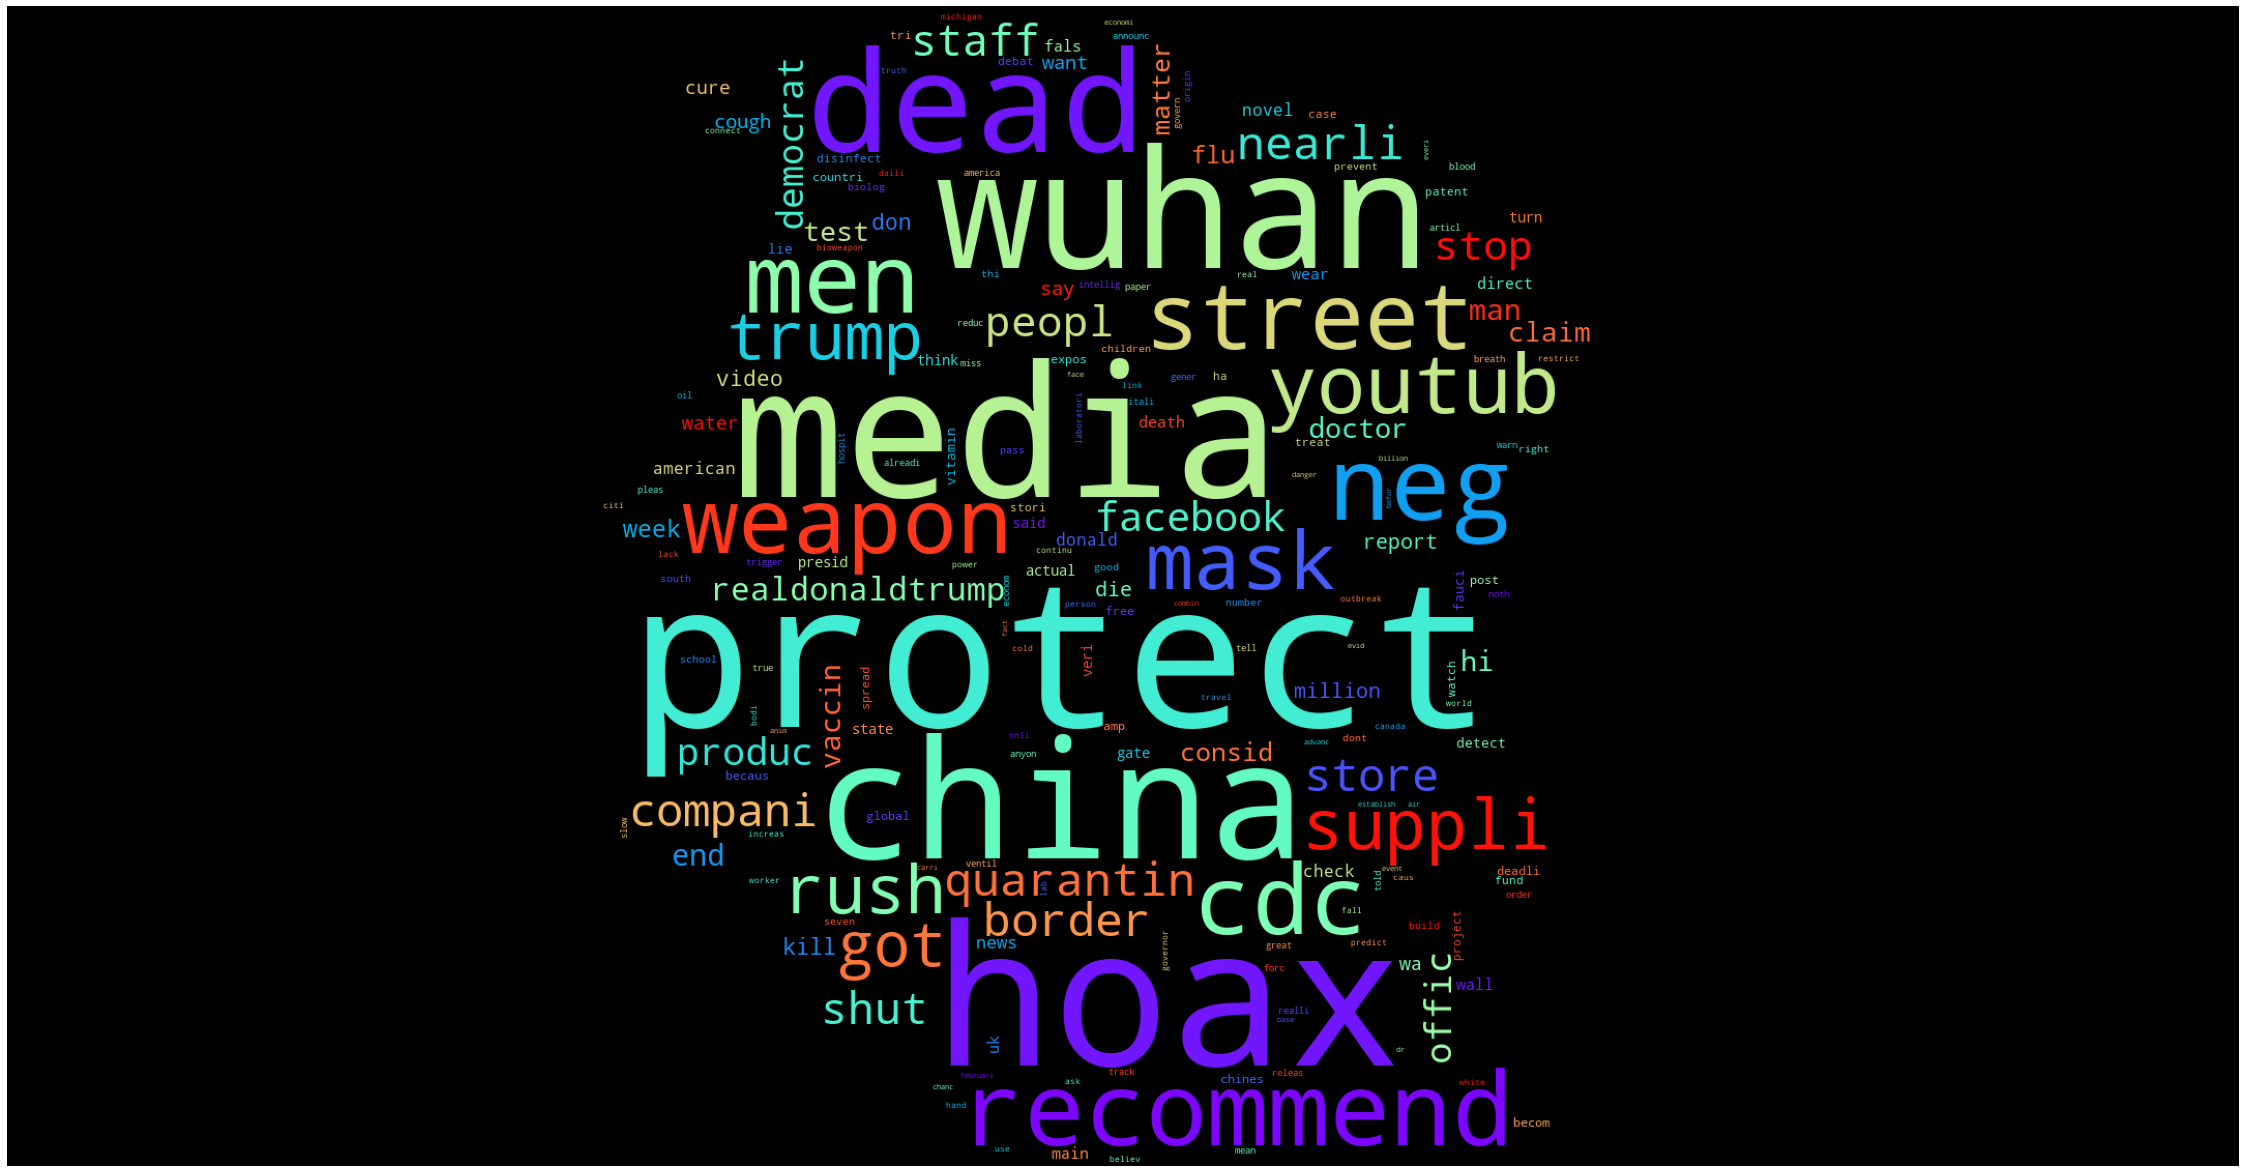

In [ ]:
plot_important_tfidf_features(X[:len(fake)], "Fake", 0.5)

# RealNews

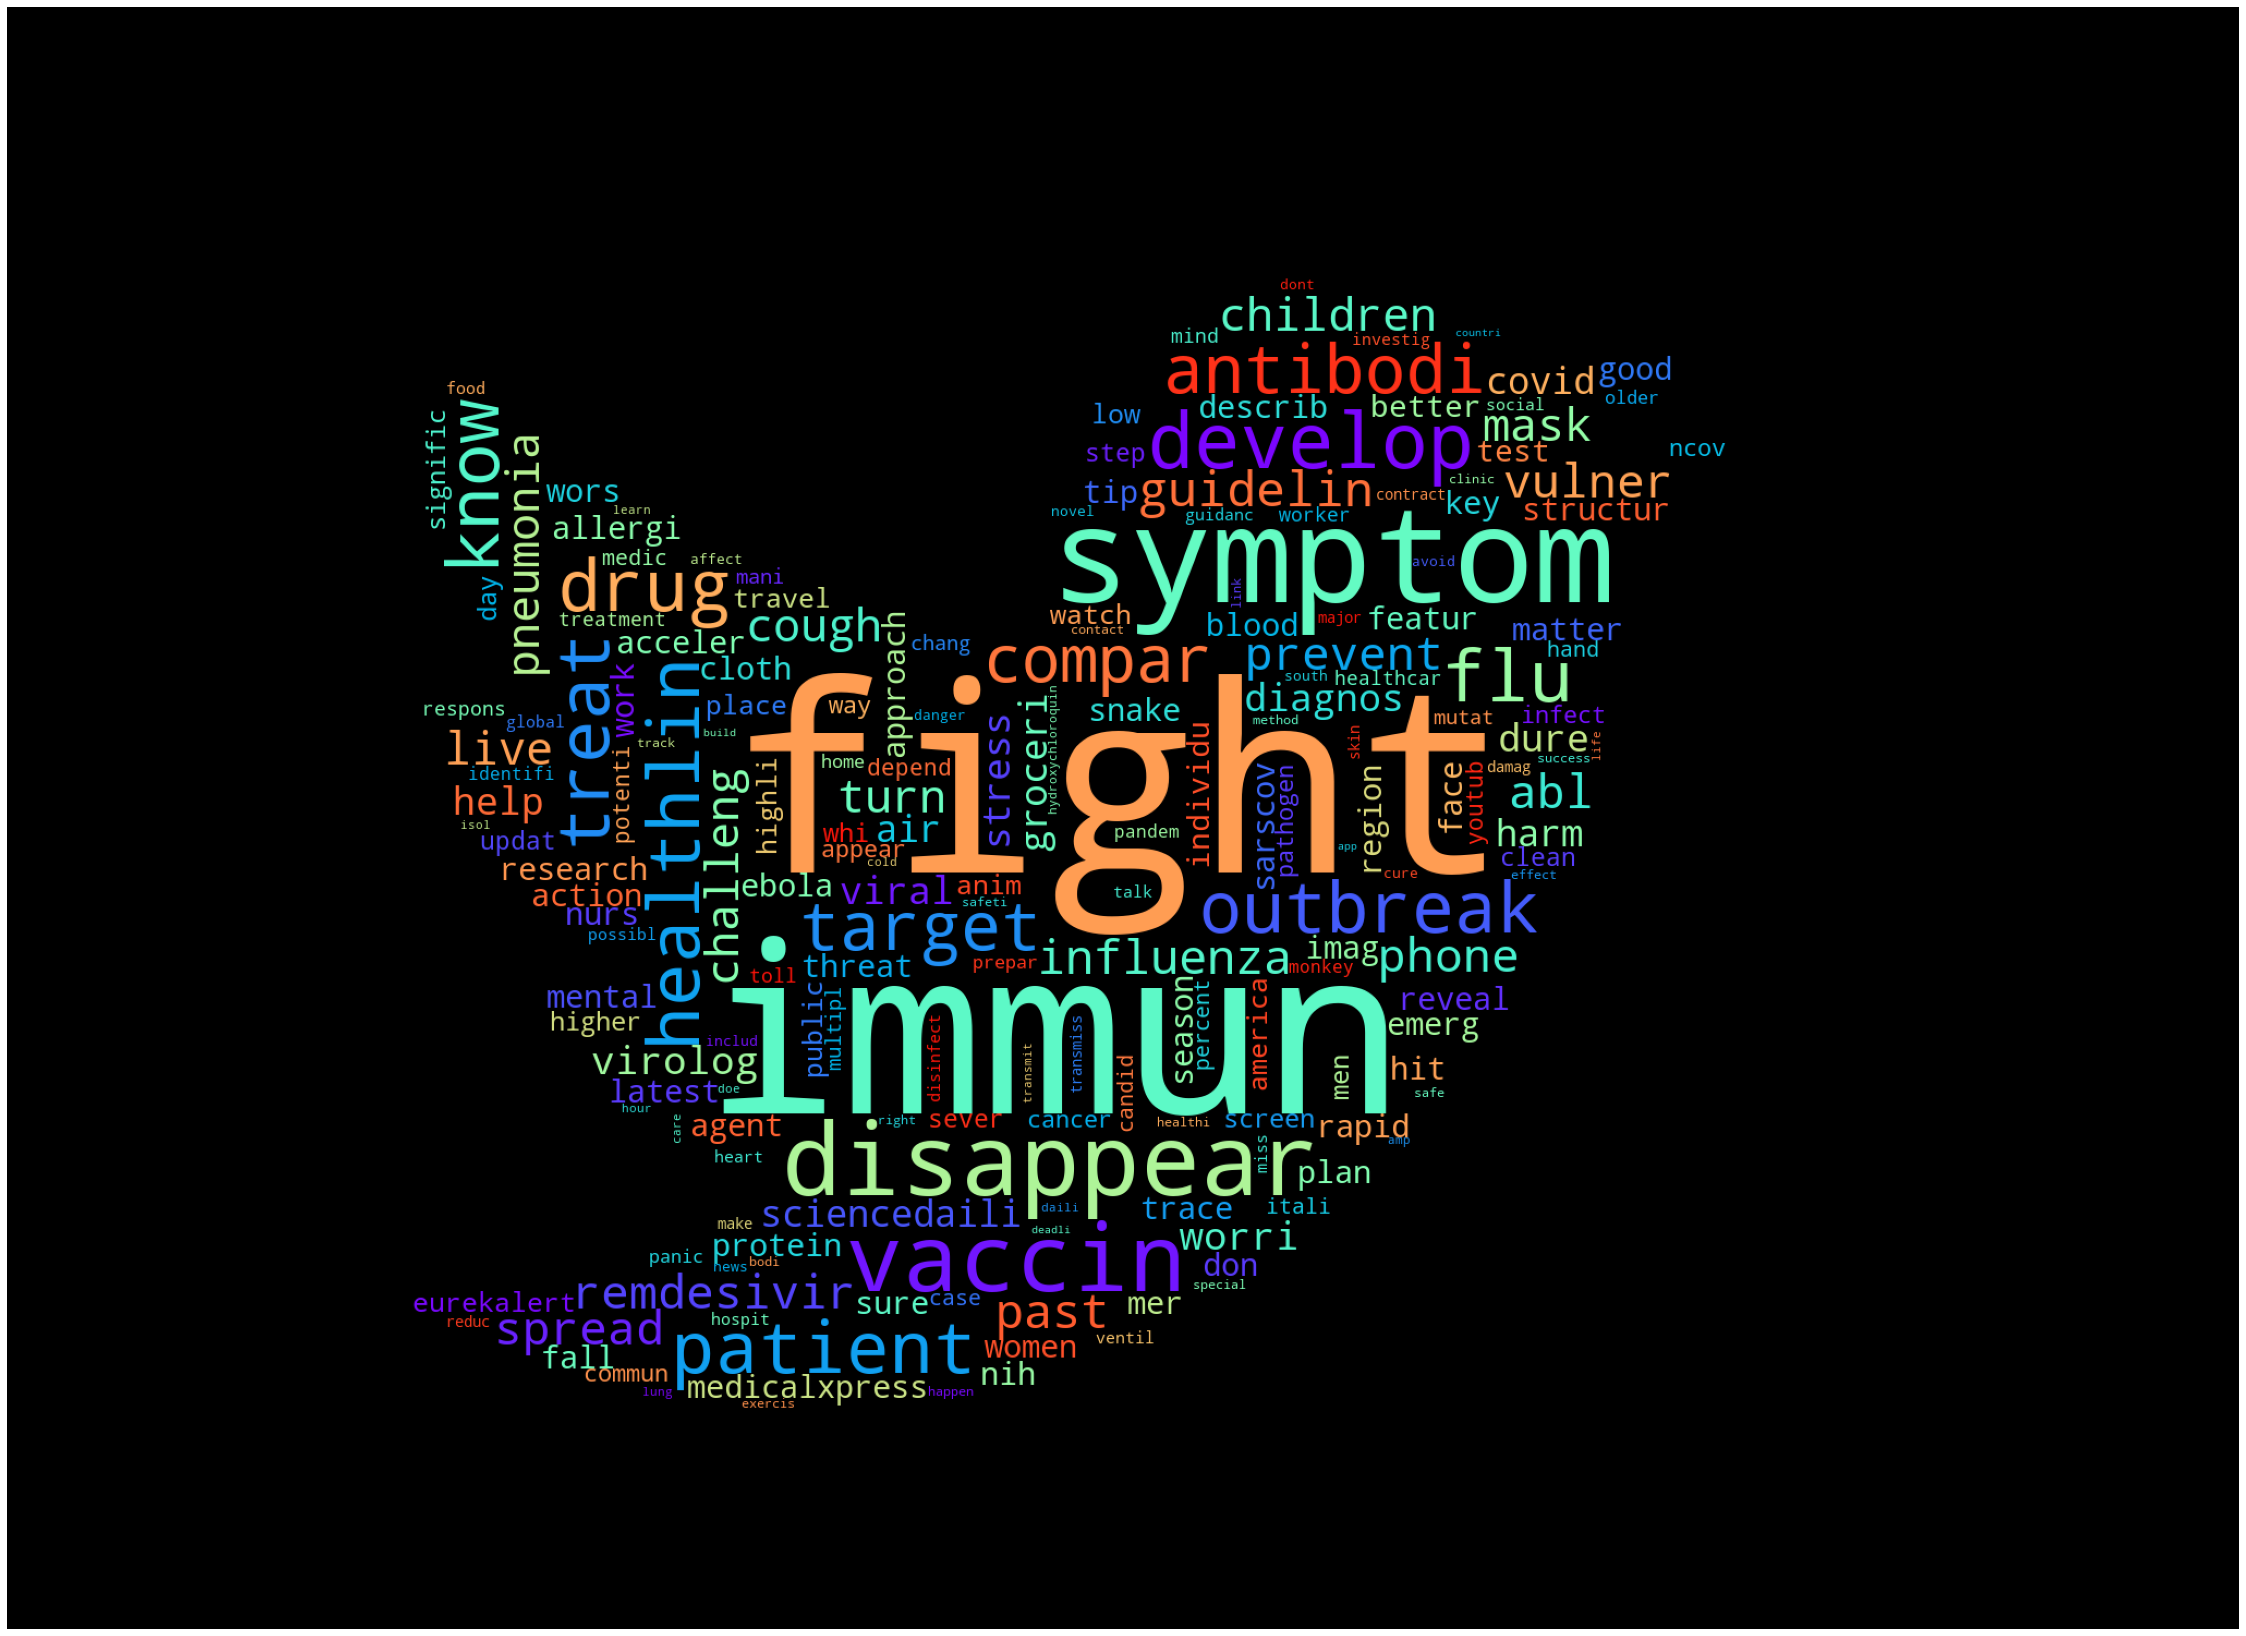

In [ ]:
plot_important_tfidf_features(X[len(fake):], "Real", 0.5)

## Alternative word cloud features

In [ ]:
#https://gist.github.com/StevenMaude/ea46edc315b0f94d03b9
def get_scores(vectorizer, tfidf_result):
  # http://stackoverflow.com/questions/16078015/
  scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_result.sum(axis=0)).ravel())
  sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
  sorted_scores = sorted_scores[0:20]
  a = [tup[0] for tup in sorted_scores]
  b = [tup[1] for tup in sorted_scores]
  a.reverse()
  b.reverse()
  return a, b 

score_fake = get_scores(tfidf, X[0:(int(len(y)/2))])
score_real= get_scores(tfidf, X[(int(len(y)/2)):])

# plot with various axes scales

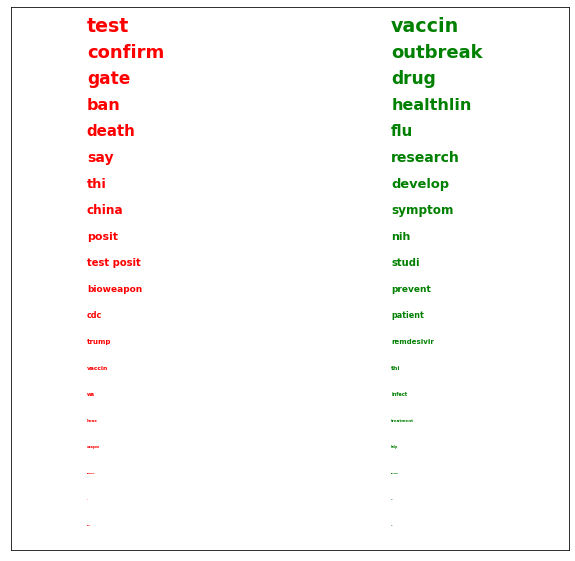

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=([0] * 20), y=np.arange(0,20),size=np.zeros(20), sizes=(0,0))
ax.set(xticks=[], yticks=[])
ax.legend().set_visible(False)

c=0
# label points on the p
for x, y in zip(([-0.04] * 20), np.arange(0,20)):
 plt.text(x= x, y=y, color="red",s = score_fake[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1

c=0
# label points on the p
for x, y in zip(([0.02] * 20), np.arange(0,20)):
 plt.text(x= x, y=y, color="green", s = score_real[0][c], fontweight="bold", fontsize=np.arange(0,22)[c])
 c = c + 1


## Bar chart features

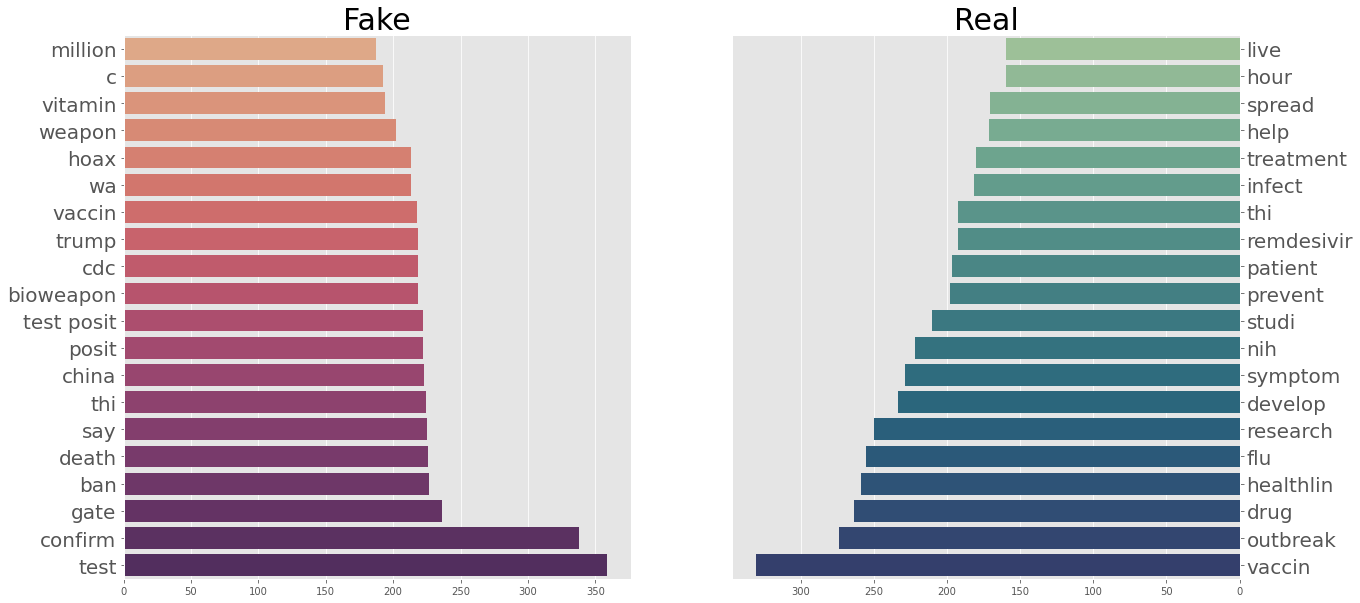

In [ ]:
with plt.style.context('ggplot'):
  f = plt.figure(figsize=(20,10))
  ax0 = plt.subplot(121)
  sns.barplot(ax=ax0, y=score_fake[0], x=score_fake[1], palette="flare")
  plt.title('Fake',fontsize=30)
  plt.yticks(fontsize=20)

  ax1 = plt.subplot(122)
  sns.barplot(ax=ax1, y=score_real[0], x=score_real[1], palette="crest")
  plt.title('Real',fontsize=30)
  ax1.yaxis.set_ticks_position("right")
  plt.yticks(fontsize=20)
  ax1.invert_xaxis()

  plt.show()

## Sparse matrix TFIDF vectors

From the following sparse matrix we can clearly see that the first half of the data (fake news) contains a consistent and bright clusters of features that co occur in documents. However, when we look at the documents in which a certain feature has a high TFIDF score, there is no consistency among documents. In the other half (real news), that is the case. We can clearly see a consistent occurence of words among all documents that have medium to high TFIDF scores.

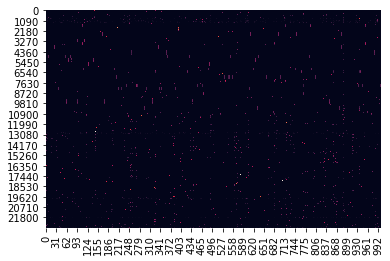

In [ ]:
# TFIDF matrix 
# y axis = document = string of words and characters 
# x axis = vector of features with elements = tfidf score --> brighter = higher

sns.heatmap(X.todense(), vmin=0, vmax=1, cbar=False)

## Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_, random_state=0, test_size=0.2, shuffle=True)

#Absolute naive classifier = predict majority class
majority = np.zeros(len(y_test))
accuracy_score(majority, y_test)

0.4860200961118392

In [ ]:

model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
print("Whitebox DecisionTree F1 with depth 3: ", model.score(X_test, y_test))
clf = LogisticRegressionCV(cv=5, scoring='f1', random_state=0, n_jobs=-1, max_iter=300).fit(X_train, y_train)
print("Blackbox LogisticRegression F1 score: ", clf.score(X_test, y_test))

Whitebox DecisionTree F1 with depth 3:  0.709480122324159
Blackbox LogisticRegression F1 score:  0.9676174136821789


In [ ]:

# Export as dot file
export_graphviz(model, out_file='tree.dot', 
                feature_names = features,
                class_names = ["Real", "Fake"])

! dot -Tpng tree.dot -o tree.png

TODO: show traversed path for a single prediction (or use LIME)

White box model DecisionTree


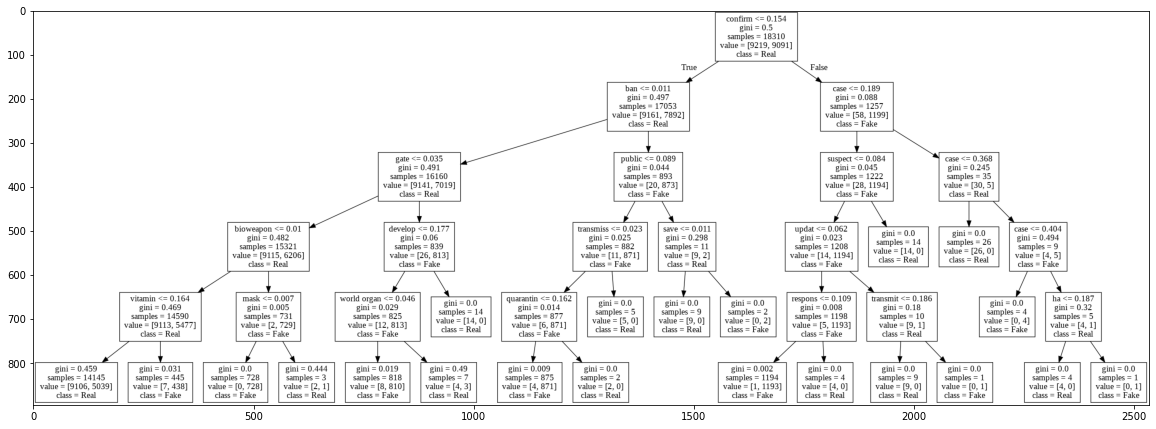

In [ ]:

img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
print("White box model DecisionTree")
plt.imshow(img)

Let's classify an example sentence, and at the same time follow the decision tree to see whether we can predict the label using the global model.

In [ ]:
sentence = "confirm"
v1 = tfidf.transform([clean(sentence)]).toarray()

def print_tfidf(vector):
  print("Features and TFIDF score: ")
  for i,k in enumerate(vector[0]):
    if k > 0:
      print("- ", features[i], k)

print_tfidf(v1)

print()
if (model.predict(v1)[0] == 1):
  print("Predicted as Fake")
else:
  print("Predicted as Real")

Features and TFIDF score: 
-  confirm 1.0

Predicted as Fake


Confusion matrix for LogisticRegression


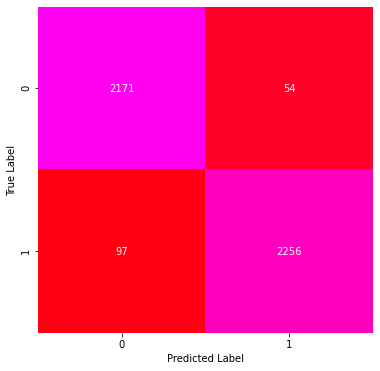

In [ ]:
print("Confusion matrix for LogisticRegression")
predictions = clf.predict(X_test)
mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,6))
sns.heatmap(mat, annot=True, fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## LIME text explain

In [ ]:
text = clean(data[2])
c = make_pipeline(tfidf, clf)
class_names = ["TRUE", "FAKE"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(text, c.predict_proba, num_features = 10)
fig = exp.show_in_notebook()

print("Ground truth: ", y_[2])

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Ground truth:  1


# Building novel Twitter bot classifier

Based on: Random Forest Twitter Bot Classifier, Schnebly et al.

## Feature mining

In [ ]:
users_real['label'] = 0
users_fake['label'] = 1
data = users_real.append(users_fake, ignore_index=True)

In [ ]:
scaler = StandardScaler()

data[["ratio", "likes_age_ratio", "followers_count", "friends_count", "favourites_count", "statuses_count", "bio_length", "username_length", "name_length", "age_account_days"]] = scaler.fit_transform(data[["ratio", "likes_age_ratio", "followers_count", "friends_count", "favourites_count", "statuses_count", "bio_length", "username_length", "name_length", "age_account_days"]])
data['label'] = data['label']

In [ ]:
data.head()

followers_count  friends_count  ...  has_location  label
0        -0.050308      -0.350524  ...             0      0
1        -0.049840      -0.290481  ...             1      0
2        -0.014379      -0.159742  ...             0      0
3        -0.055454      -0.373444  ...             1      0
4        -0.010262       0.022970  ...             1      0

[5 rows x 17 columns]

## Feature importance

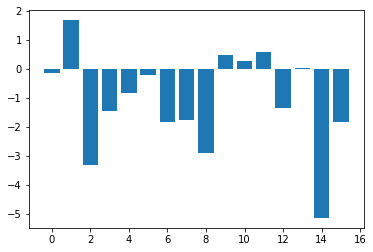

In [ ]:
#https://machinelearningmastery.com/calculate-feature-importance-with-python/

# define dataset
def plot_fimp_log(X,y):
  model = LogisticRegression()
  # fit the model
  model.fit(X,y)
  # get importance
  importance = model.coef_[0]
  # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  plt.show()

plot_fimp_log(data.drop(['label'], axis=1), data['label'])

In [ ]:
X = data.drop(['label'], axis=1)
y = data['label']

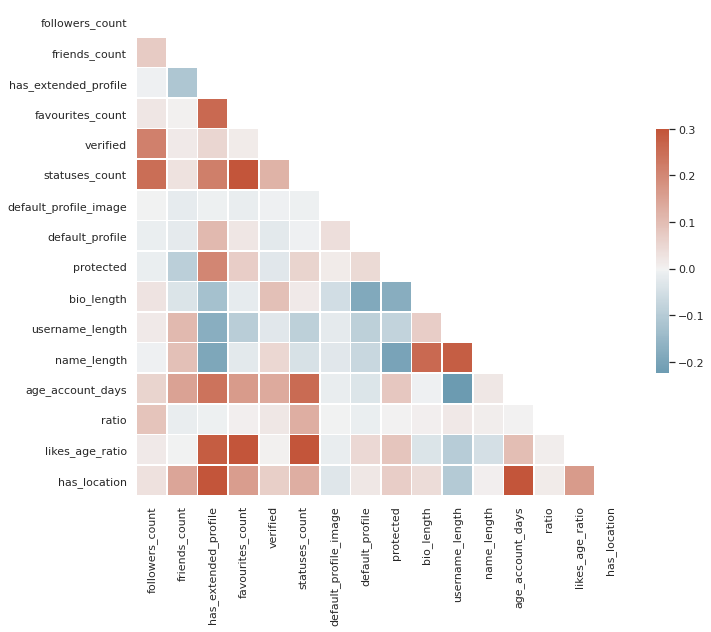

In [ ]:
sns.set_theme(style="white")

# Generate a large random dataset

d = X

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, shuffle=True)

# baseline classifier
majority = np.zeros(len(y_test))
accuracy_score(majority, y_test)

0.512280701754386

In [ ]:
# define the model
bot_model = RandomForestClassifier(n_estimators=13)
#model = LogisticRegression(max_iter=300)

# fit the model
bot_model.fit(X_train,y_train)
preds_ = bot_model.predict(X_test)
f1_score(preds_, y_test)

0.98

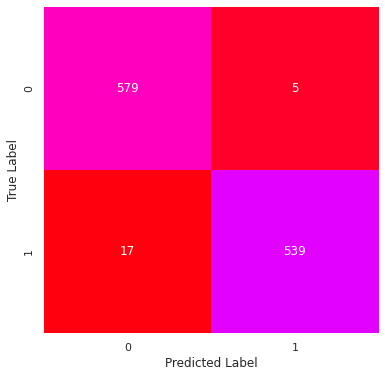

In [ ]:
mat = confusion_matrix(y_test, preds_)
plt.figure(figsize=(6,6))
sns.heatmap(mat, annot=True,   fmt='d', cmap=plt.cm.gist_rainbow, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## LIME tabular explain

In [ ]:
i = 10
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns, mode='classification')
exp = explainer.explain_instance(X_test.iloc[i], bot_model.predict_proba)
print("Ground truth: ", y_test.iloc[i])
exp.show_in_notebook(show_table=True)

Ground truth:  0



# Export trained models, user study data and explanation interface

## Social bot detected ( bot ∈ {0,1} )

In [ ]:
# first preprocess users 
# usage 
#bot_model.predict(X_users)

## Social impact score ( score ∈ N )

Arbitrary linear score, see plot for importance

In [ ]:
score = 2 * tweets['retweet_count'] + tweets['favorite_count']

## Classified as fake news by TF IDF ( fake ∈ {0,1} )

In [ ]:
# usage
#words = tfidf.transform([clean(tweet['full_text'])]).toarray()
#clf.predict(words)

## Text features

TODO: take intersection of hashtags that occur in both fake and real news, delete from fake news hashtag -> X

Do check and warn user if a hashtag is an element of X

In [ ]:
#extract hashtag from tweet
#tweets["hashtag"] = tweets["full_text"].apply(lambda x: re.findall(r"#(\w+)", x))
# check if any occur in bad hashtags
# len([i for i in k["hashtag"] if i in fake_news_hashtags])>0

## Dataframes for user study

In [ ]:
tweets_real = pd.read_json("data_real_tweets.json")
tweets_fake = pd.read_json("data_fake_tweets.json")
tweets_real_users_study = pd.read_json("data_real_users.json")
tweets_fake_users_study = pd.read_json("data_fake_users.json")

In [ ]:
def df_to_json(dataframe, name):
  result = dataframe.to_json(orient="records")
  parsed = json.loads(result)
  with open('Junk/data_' +name+'.json', 'w') as out:
    json.dump(parsed, out)

In [ ]:
tweets_real.sort_values(by=["retweet_count", "favorite_count"], ascending=False)

id  ... possibly_sensitive
7728  1256110894985154560  ...              False
7689  1256026484617207809  ...              False
7141  1236623843470393344  ...              False
6227  1240514631355060230  ...              False
7553  1256339577276715009  ...              False
...                   ...  ...                ...
9994  1250486927440195587  ...              False
9996  1250488333811068928  ...              False
9997  1250489533361258498  ...              False
9998  1250489831638970368  ...              False
9999  1250489926883381248  ...              False

[10000 rows x 6 columns]

In [ ]:
df_to_json(tweets_real.loc[[7728, 6227, 7553]], "real_tweets")

In [ ]:
df_to_json(tweets_real_users_study.loc[[7728, 6227, 7553]], "real_users")

In [ ]:
tweets_real_users_study.loc[[7728, 6227, 7553]]

id                       name  ... likes_age_ratio  has_location
7728   610659001                  Max Roser  ...        8.634853             1
6227  1352962327  ɪᴀɴ ᴍ. ᴍᴀᴄᴋᴀʏ, ᴘʜᴅ 🦠🤧🧬🥼🦟🧻  ...       29.459899             1
7553    14260960             Justin Trudeau  ...        0.024517             1

[3 rows x 30 columns]

In [ ]:
tweets_fake.sort_values(by=["retweet_count", "favorite_count"], ascending=False)[0:20]

id  ... possibly_sensitive
9620  1241447017945223169  ...              False
9602  1240768501452697600  ...              False
9600  1240676575168921600  ...              False
9617  1241337295606657033  ...              False
9604  1241057919128526856  ...              False
9591  1235791843926761475  ...              False
9615  1241287878354677760  ...              False
9649  1242476408896507910  ...              False
9585  1235714275752267776  ...              False
9613  1241247329572683776  ...              False
9598  1240618235499819008  ...              False
9601  1240722087381262337  ...              False
9599  1240647292543262721  ...              False
9627  1241789646037602307  ...              False
9642  1242228808264155138  ...              False
9652  1242540756209774592  ...              False
9582  1235674258858061825  ...              False
9671  1234964653014384644  ...              False
9631  1241904709583155206  ...              False
9580  1235436227140055040  ...              False

[20 rows x 6 columns]

In [ ]:
df_to_json(tweets_fake.loc[[9598, 9642, 9582]], "fake_tweets")

In [ ]:
df_to_json(tweets_fake_users_study.loc[[9598, 9642, 9582]], "fake_users")

In [ ]:
tweets_fake_users_study.loc[[9598, 9642, 9582]]

id              name  ... likes_age_ratio  has_location
9598   237869476                iO  ...        4.130641             1
9642   605153786   Leana Wen, M.D.  ...        2.453186             1
9582  1651522832  Dr. Dena Grayson  ...       63.093444             1

[3 rows x 30 columns]